In [1]:
import os, sys
sys.path.append('..') # Parent directory in path
import time, pickle
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib.pylab as pl
import statsmodels.api as sm

pd.set_option("display.precision", 4)
import pandas_market_calendars as mcal # NYSE Calendar

import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rc("font", **{"size": 14})
plt.rc("figure", **{"figsize": (16,10)})

from engine import HyperbolaModel, SingleExp, AllExp

C:\Users\plee\AppData\Local\Temp\ipykernel_7268\3043739382.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
MODEL = "hyperbola"

with open(f"{MODEL}_fits_naive.pkl", "rb") as f:
    framework = pickle.load(f)

ivts = pd.concat([pd.read_hdf(os.path.join("..", "data", "spx_iv_db_1.h5")), 
                  pd.read_hdf(os.path.join("..", "data", "spx_iv_db_2.h5"))])

otm_mask = (  ((ivts["TYPE"]=='C') & (ivts["STRIKE"]> ivts["UNDERLYING_PRICE"])) 
            | ((ivts["TYPE"]=='P') & (ivts["STRIKE"]<=ivts["UNDERLYING_PRICE"])))

otm  = ivts[otm_mask].dropna().reset_index(drop=True)

otm["LOG_MONEYNESS_F"] = np.log(otm["STRIKE"]/otm["F_T"])
otm["IVAR_MID"] = otm["IV_MID"]**2

framework.reload_data(otm)

In [3]:
with open(f"{MODEL}_fits_med.pkl", "rb") as f:
    framework_med = pickle.load(f)

framework_med.reload_data(otm)

C:\Users\plee\miniconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


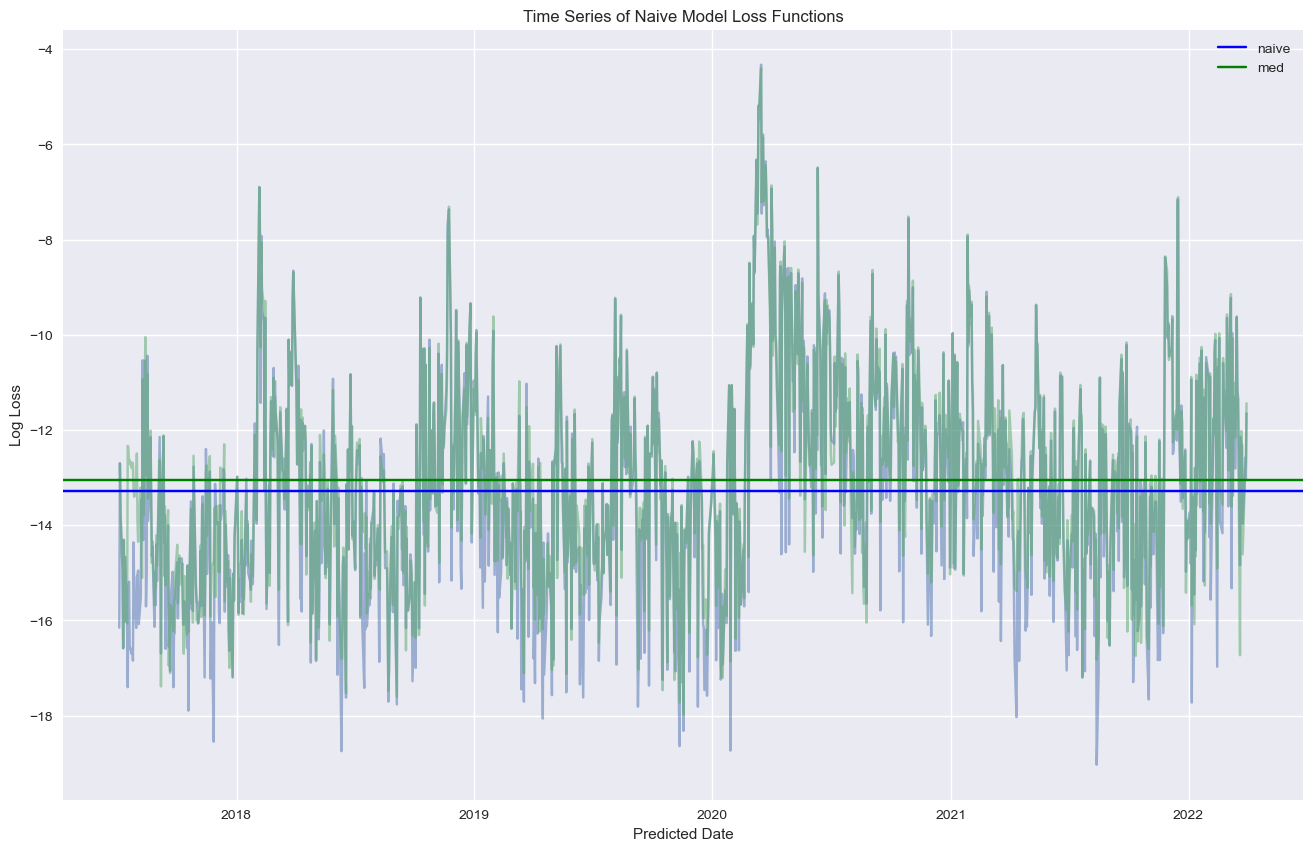

In [23]:
losses = []
for single in framework.exps:
    df = pd.DataFrame({"TS": single.dayu, "LOSS": single.losses})
    df["EXP"] = single.exp
    losses.append(df)
    
losses = pd.concat(losses)
loss_med = losses.groupby("TS").median(numeric_only=True)

to_plot_med = loss_med[loss_med["LOSS"] > 0]


to_plot = losses[losses["LOSS"] > 0]

losses = []
for single in framework_med.exps:
    df = pd.DataFrame({"TS": single.dayu, "LOSS": single.losses})
    df["EXP"] = single.exp
    losses.append(df)
    
losses_med = pd.concat(losses)
loss_med_med = losses_med.groupby("TS").median(numeric_only=True)

to_plot_med_med = loss_med_med[loss_med["LOSS"] > 0]

# plt.scatter(to_plot["TS"], np.log(to_plot["LOSS"]), alpha=0.1)
plt.plot(to_plot_med.index, np.log(to_plot_med["LOSS"]), alpha=0.5)
plt.plot(to_plot_med_med.index, np.log(to_plot_med_med["LOSS"]), alpha=0.5)

plt.axhline(np.log(to_plot_med["LOSS"]).mean(), color='b', label="naive")
plt.axhline(np.log(to_plot_med_med["LOSS"]).mean(), color='g', label="med")

plt.title("Time Series of Naive Model Loss Functions")
plt.legend()
plt.xlabel("Predicted Date")
plt.ylabel("Log Loss")
plt.show()

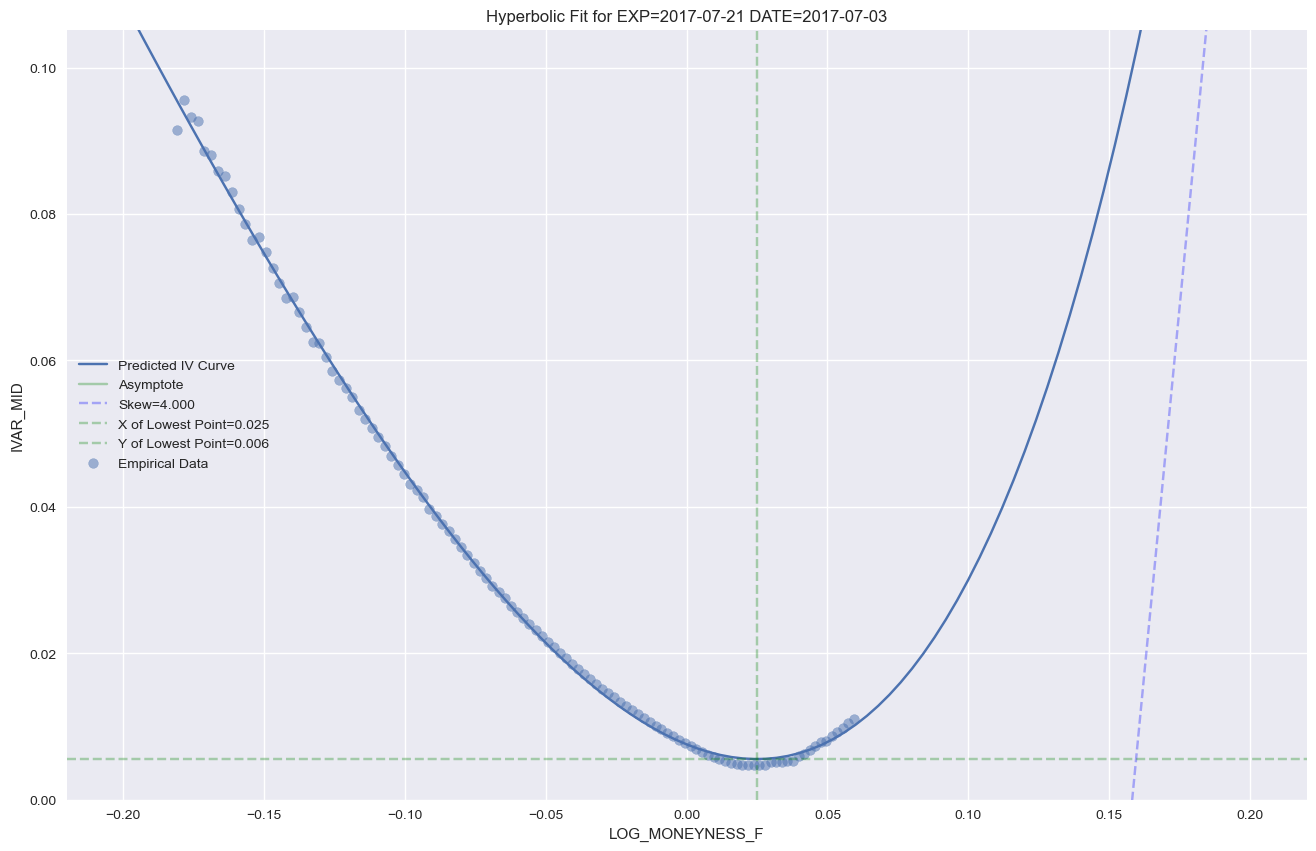

In [3]:
framework.exps[0].plot_day(0)

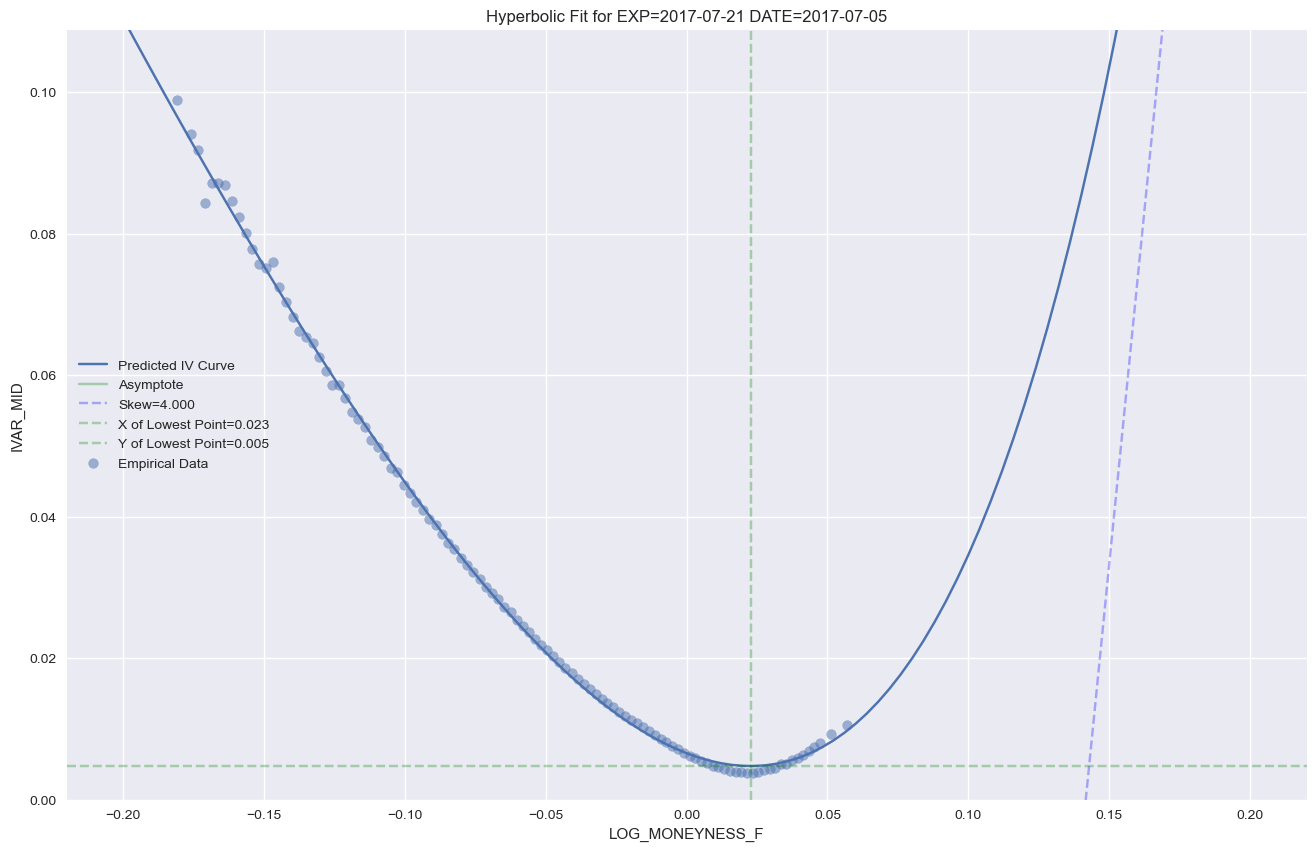

In [4]:
framework.exps[0].plot_day(1)

In [5]:
param_cols = [chr(i) for i in range(97,102)]

param_ts = []
for single in framework.exps:
    df = pd.DataFrame(single.dayu, columns=["TS"])
    df["EXP"]       = single.exp
    df[param_cols]  = single.fits
    param_ts.append(df)

param_ts = pd.concat(param_ts)

param_ts["ASYM"] = param_ts['b'] / param_ts['a'] + param_ts['d']
param_ts["X*"] = framework.model.function_minimizer(param_ts['a'], param_ts['b'], param_ts['c'], param_ts['d'], param_ts['e'])
param_ts["Y*"] = framework.model.function(param_ts["X*"], param_ts['a'], param_ts['b'], param_ts['c'], param_ts['d'], param_ts['e'])

param_ts = param_ts[param_ts['a']!=0]
param_ts.to_pickle(f"{MODEL}_params.pkl")
param_ts

TS        EXP       a       b       c       d       e    ASYM  \
0  2017-07-03 2017-07-21  0.1677  0.8482  0.2418  4.0000 -0.5134  9.0570   
1  2017-07-05 2017-07-21  0.1461  0.7331  0.2154  4.0000 -0.4381  9.0193   
2  2017-07-06 2017-07-21  0.1265  0.6340  0.1978  4.0000 -0.3765  9.0122   
3  2017-07-07 2017-07-21  0.1742  0.9214  0.2229  4.0000 -0.5982  9.2884   
4  2017-07-10 2017-07-21  0.1639  0.8767  0.2001  4.0000 -0.5775  9.3486   
..        ...        ...     ...     ...     ...     ...     ...     ...   
25 2022-03-25 2023-03-17  0.0446  0.0030  0.1041 -0.1054  0.0238 -0.0382   
26 2022-03-28 2023-03-17  0.0512  0.0036  0.1018 -0.1049  0.0227 -0.0345   
27 2022-03-29 2023-03-17  0.0554  0.0043  0.1029 -0.0968  0.0210 -0.0193   
28 2022-03-30 2023-03-17  0.0478  0.0033  0.0997 -0.1060  0.0233 -0.0373   
29 2022-03-31 2023-03-17  0.0374  0.0023  0.1028 -0.1156  0.0252 -0.0555   

        X*      Y*  
0   0.0250  0.0055  
1   0.0227  0.0047  
2   0.0302  0.0056  
3   0.0215  0.0045  
4   0.0155  0.0045  
..     ...     ...  
25     NaN     NaN  
26     NaN     NaN  
27     NaN     NaN  
28     NaN     NaN  
29     NaN     NaN  

[11110 rows x 10 columns]

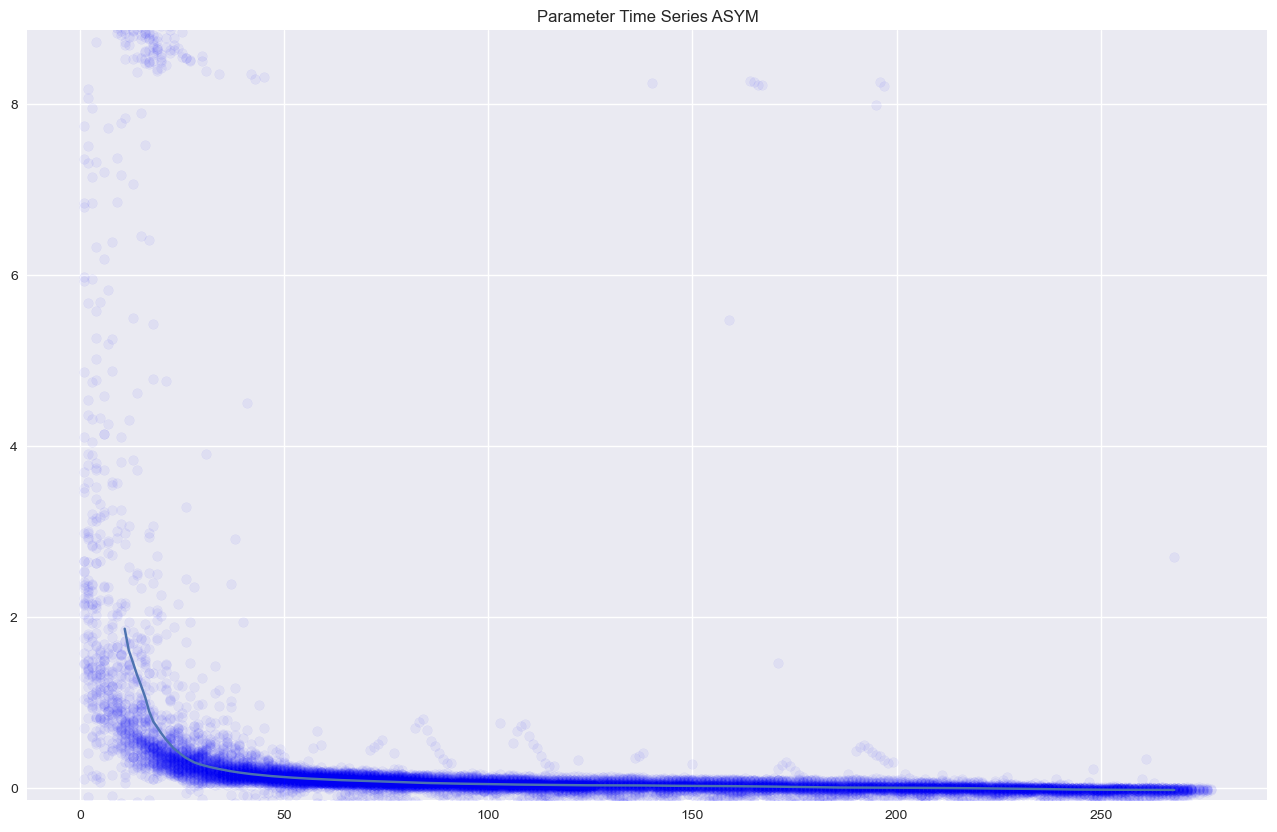

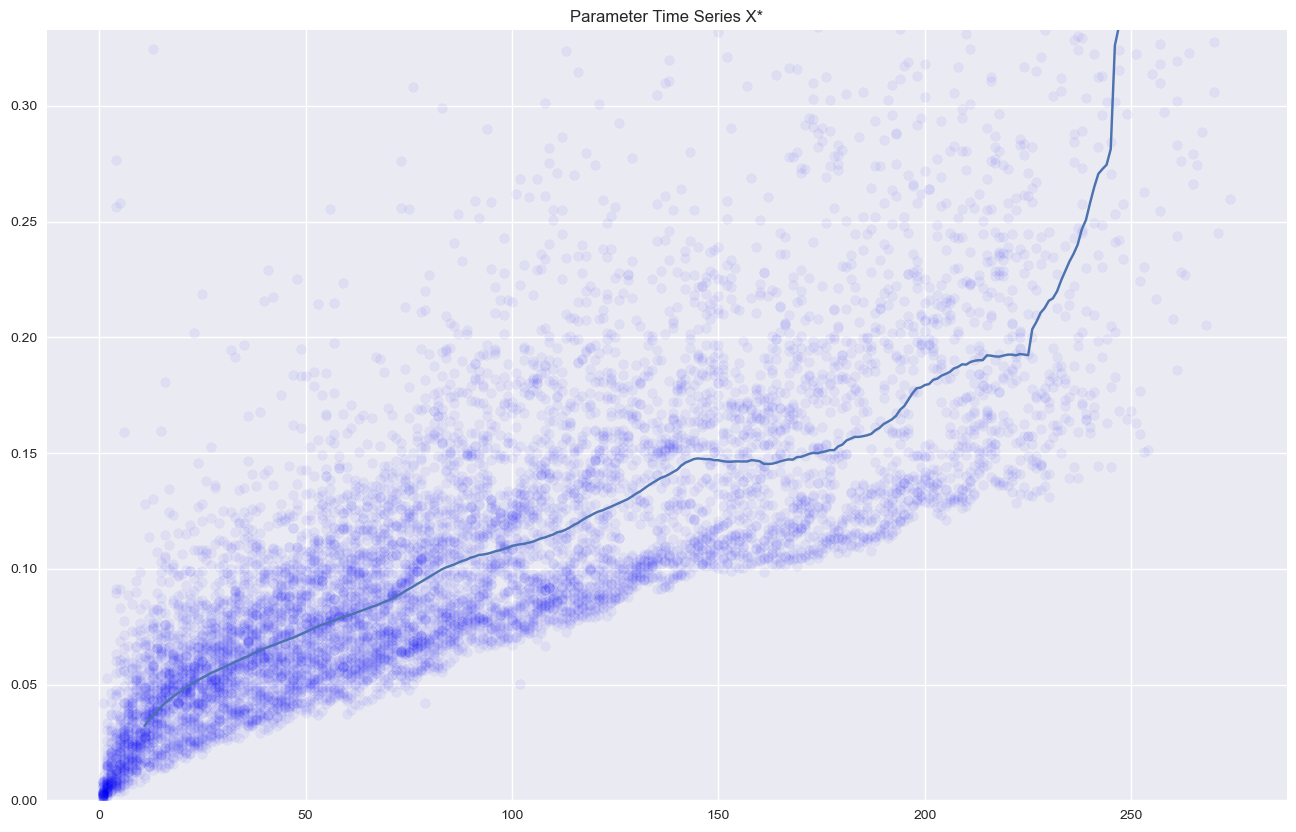

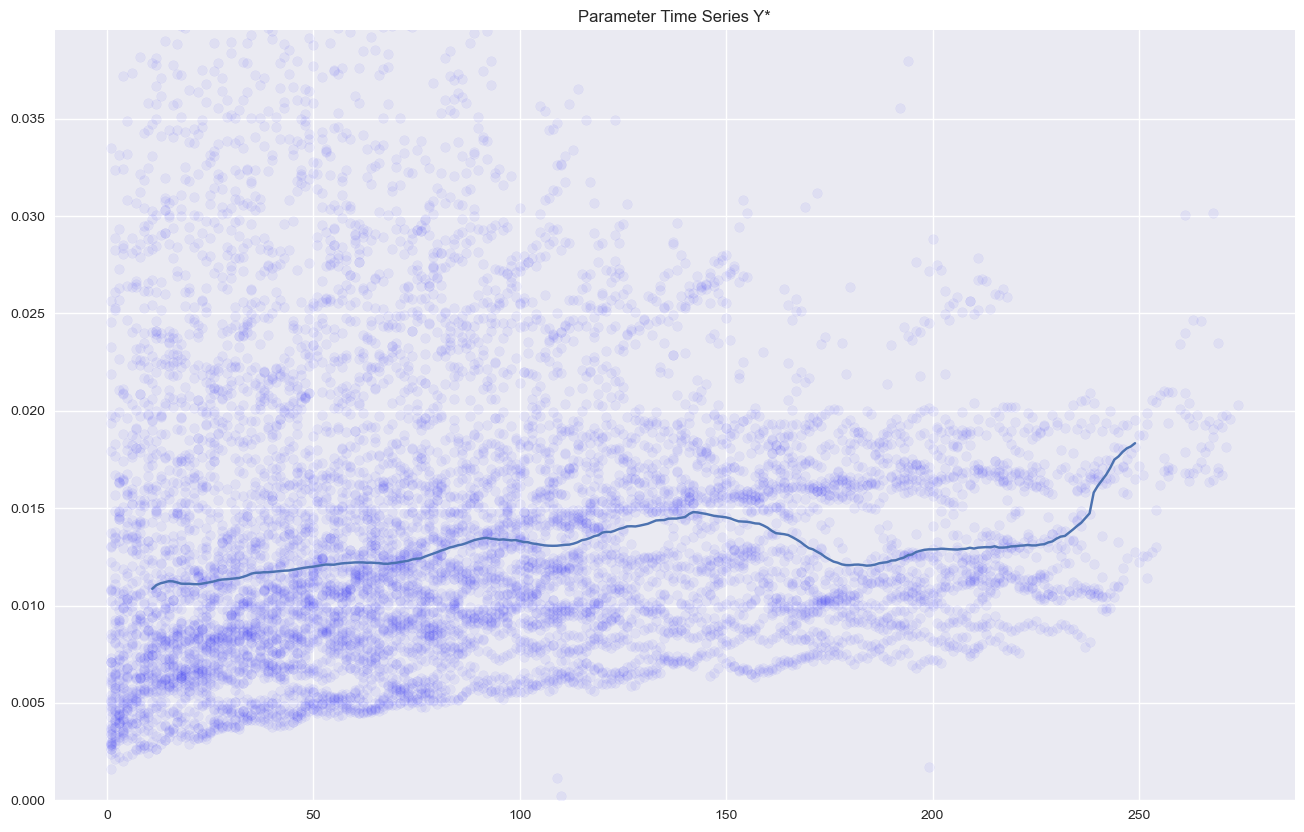

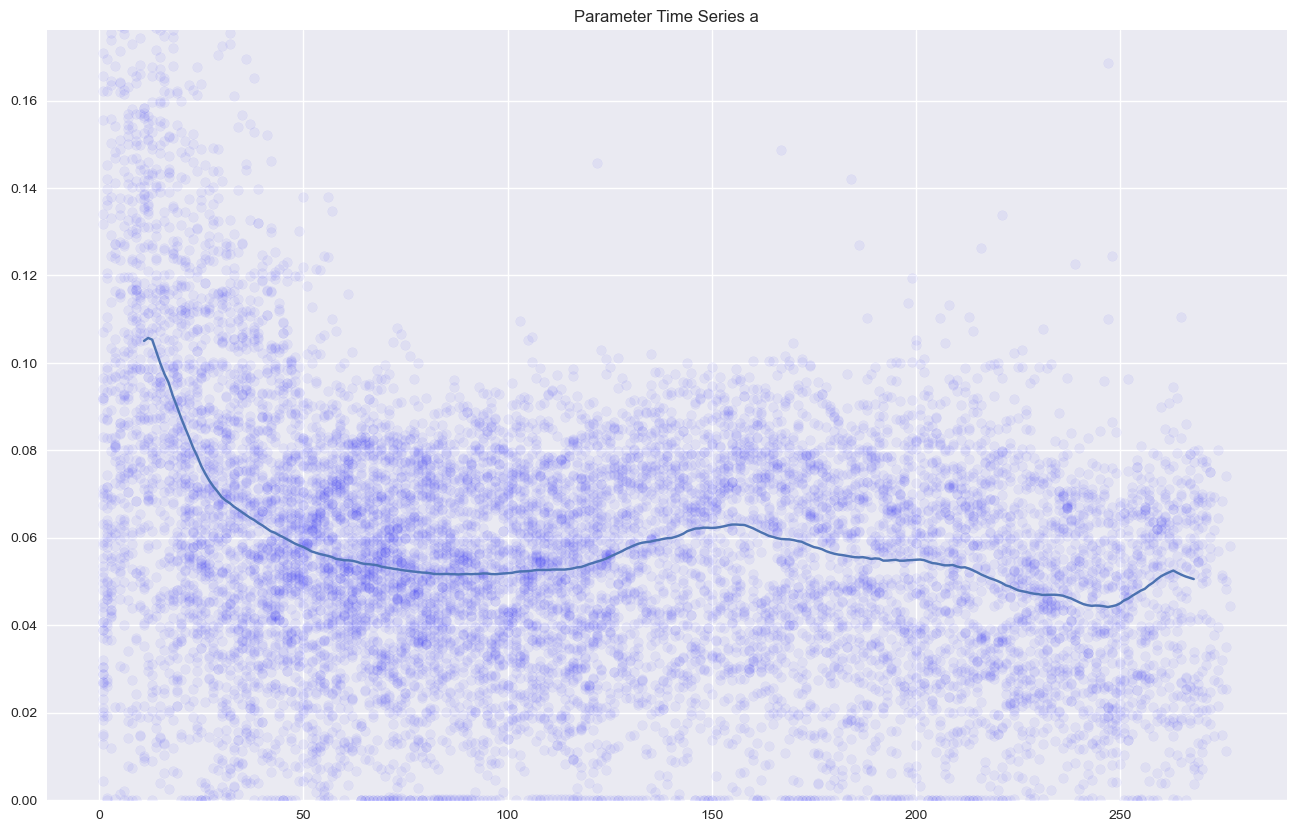

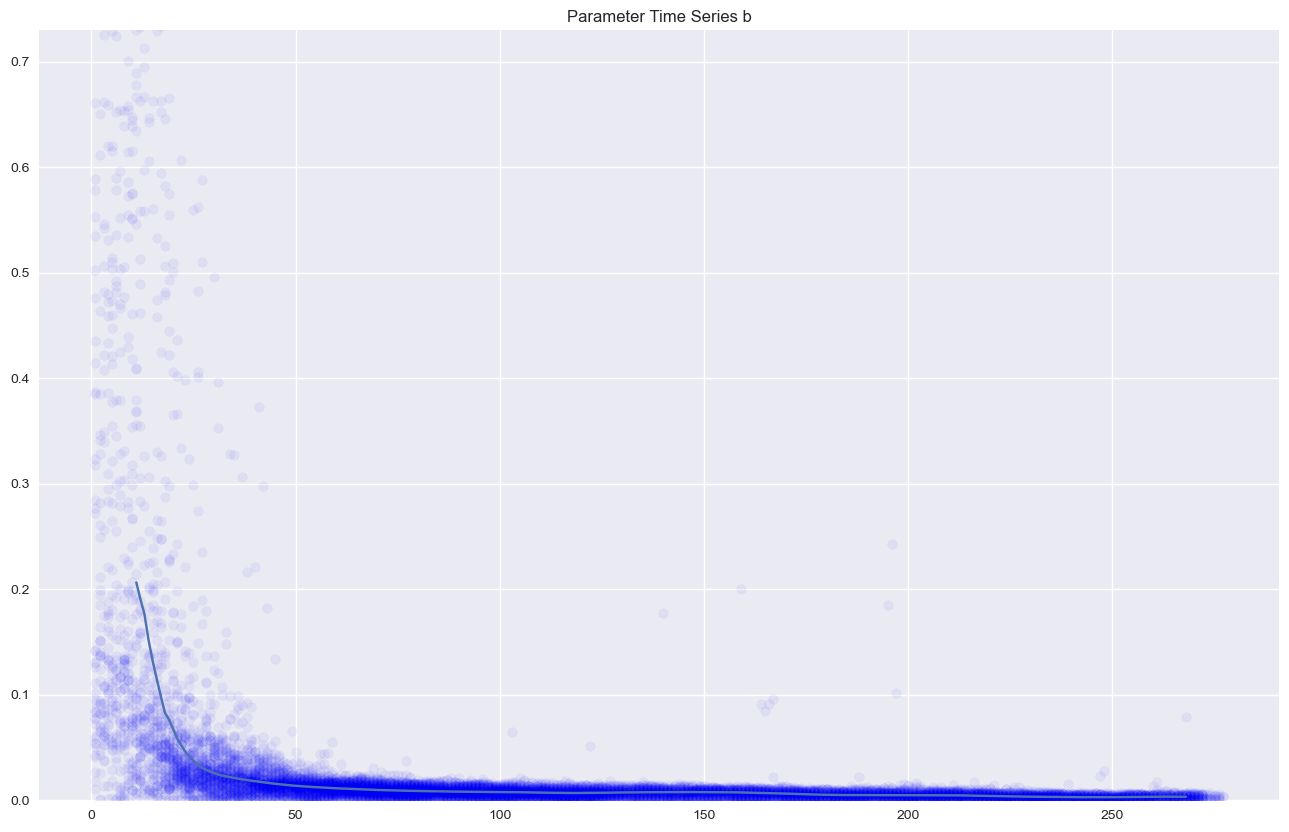

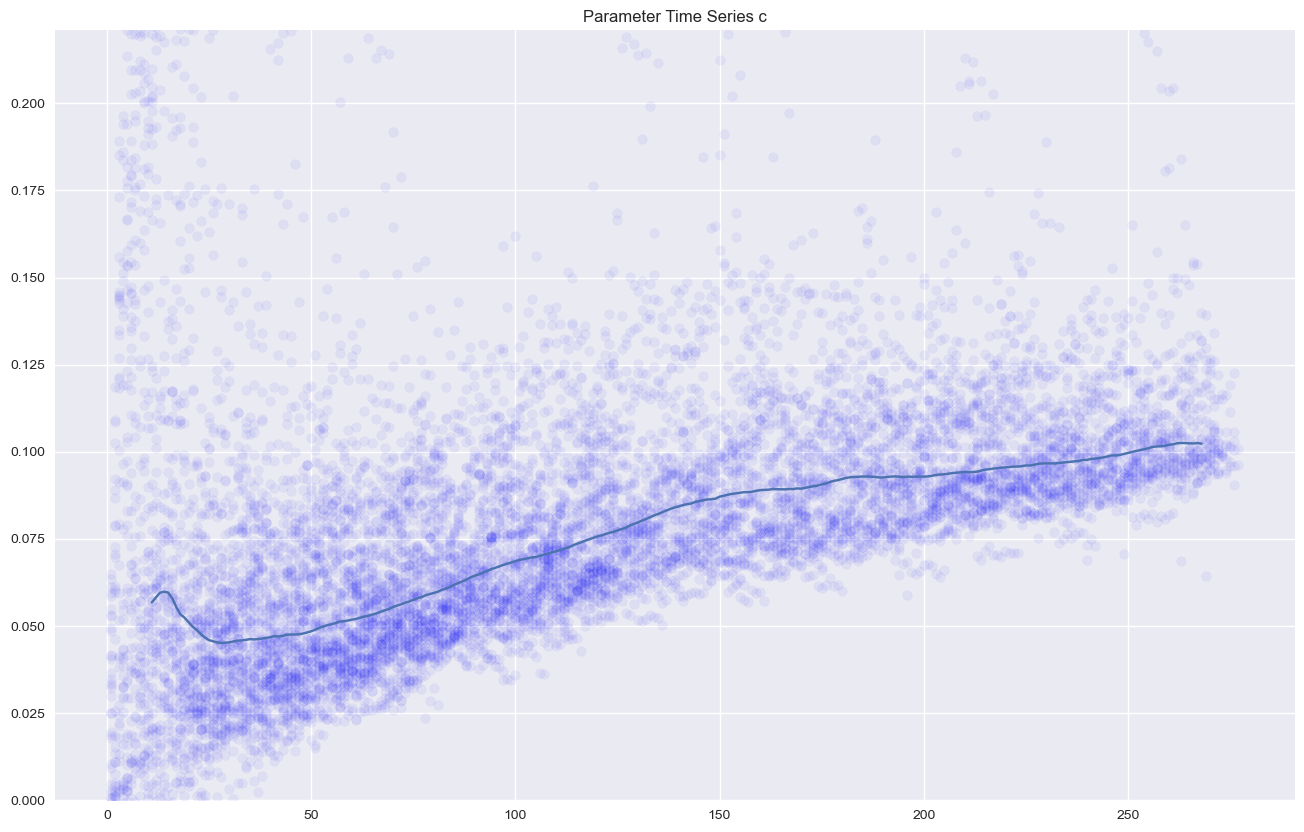

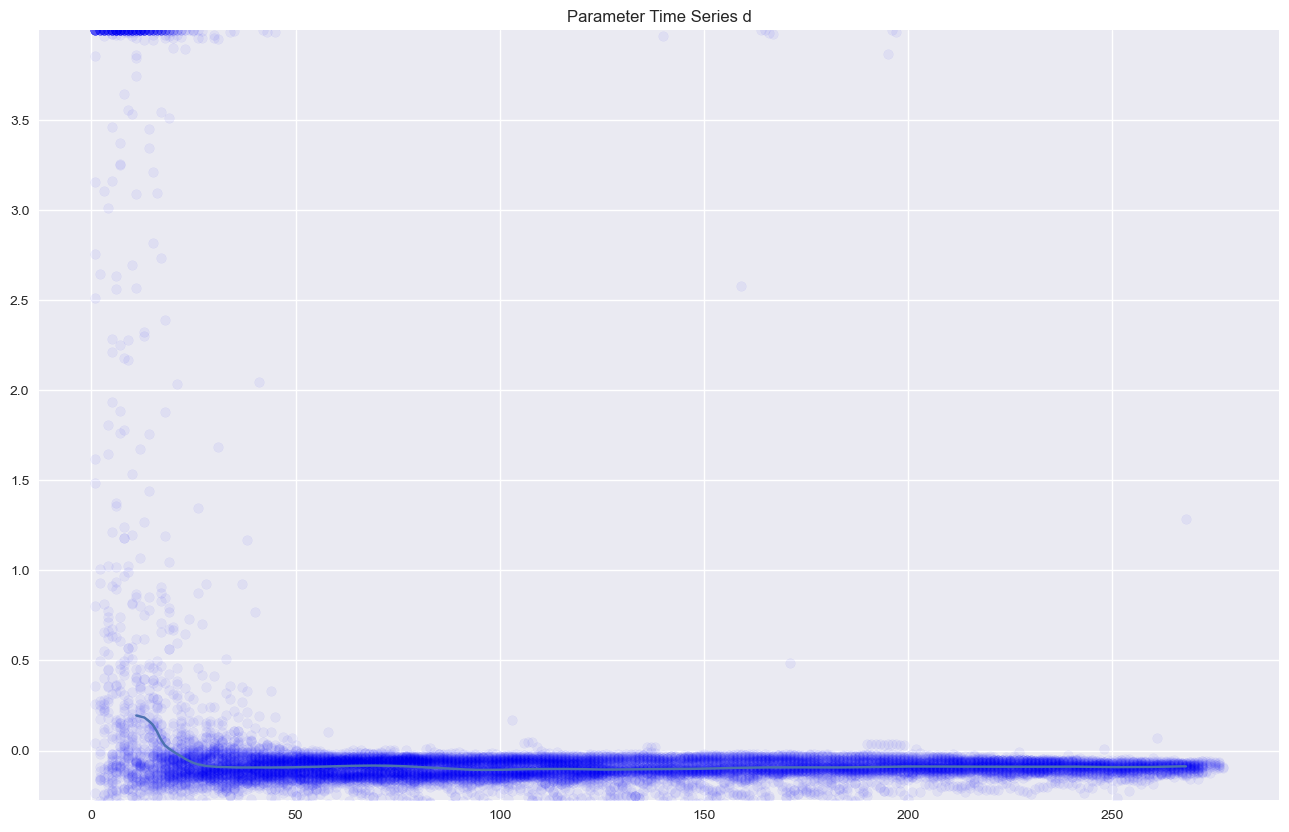

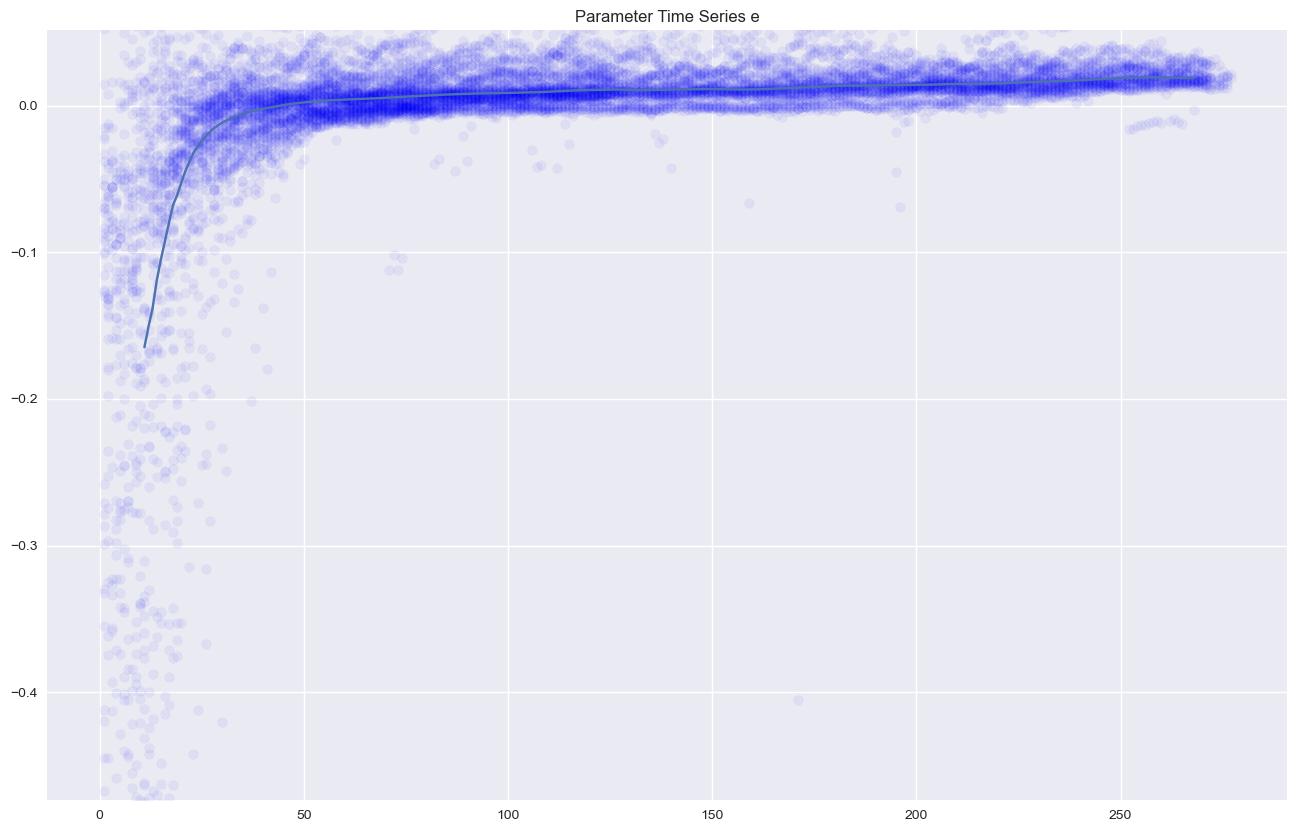

In [6]:
QT = 0.025
win = 20

cols = ["ASYM", "X*", "Y*"] + param_cols

holidays = mcal.get_calendar('NYSE').holidays()
holidays = list(holidays.holidays) # NYSE Holiday

param_ts["BUS_DAYS"] = np.busday_count([d.date() for d in param_ts["TS"]], 
                                  [d.date() for d in param_ts["EXP"]], 
                                  holidays=holidays)
param_med = param_ts.groupby("BUS_DAYS").median(numeric_only=True).reset_index()
param_med[cols] = param_med[cols].rolling(win, 
    win_type="gaussian", center=True).mean(std=win/2)

for c in cols:
    for exp in framework.expu:
        if True: #pd.to_datetime(exp).month%3==0:
            plt.scatter(param_ts.loc[param_ts["EXP"]==exp, "BUS_DAYS"], 
                     param_ts.loc[param_ts["EXP"]==exp, c], color='b', 
                     alpha=0.05, label=exp)
    
    plt.plot(param_med["BUS_DAYS"], param_med[c])
    
    # plt.legend()
    plt.title(f"Parameter Time Series {c}")
    plt.ylim([min(param_ts[c].quantile(QT), 0), 
              param_ts[c].quantile(1-QT)])
    plt.show()

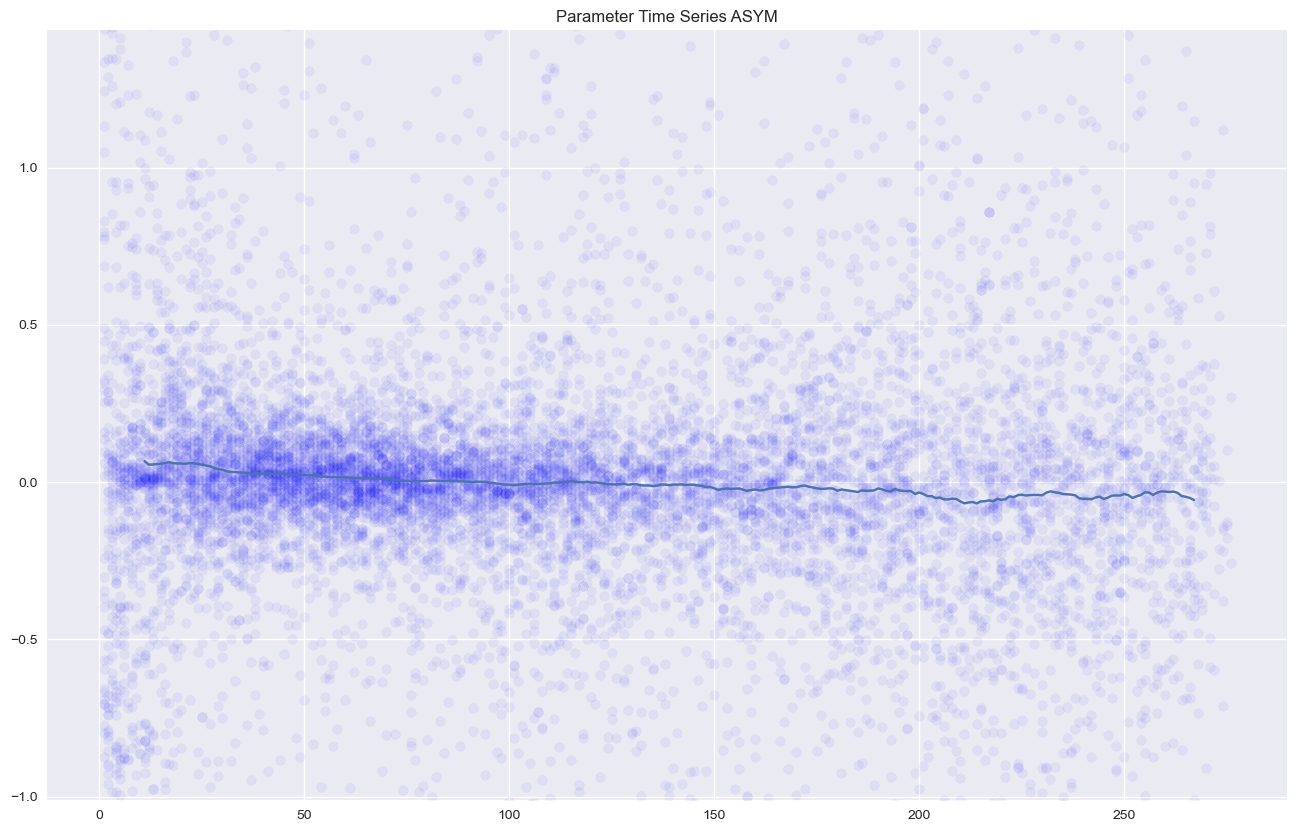

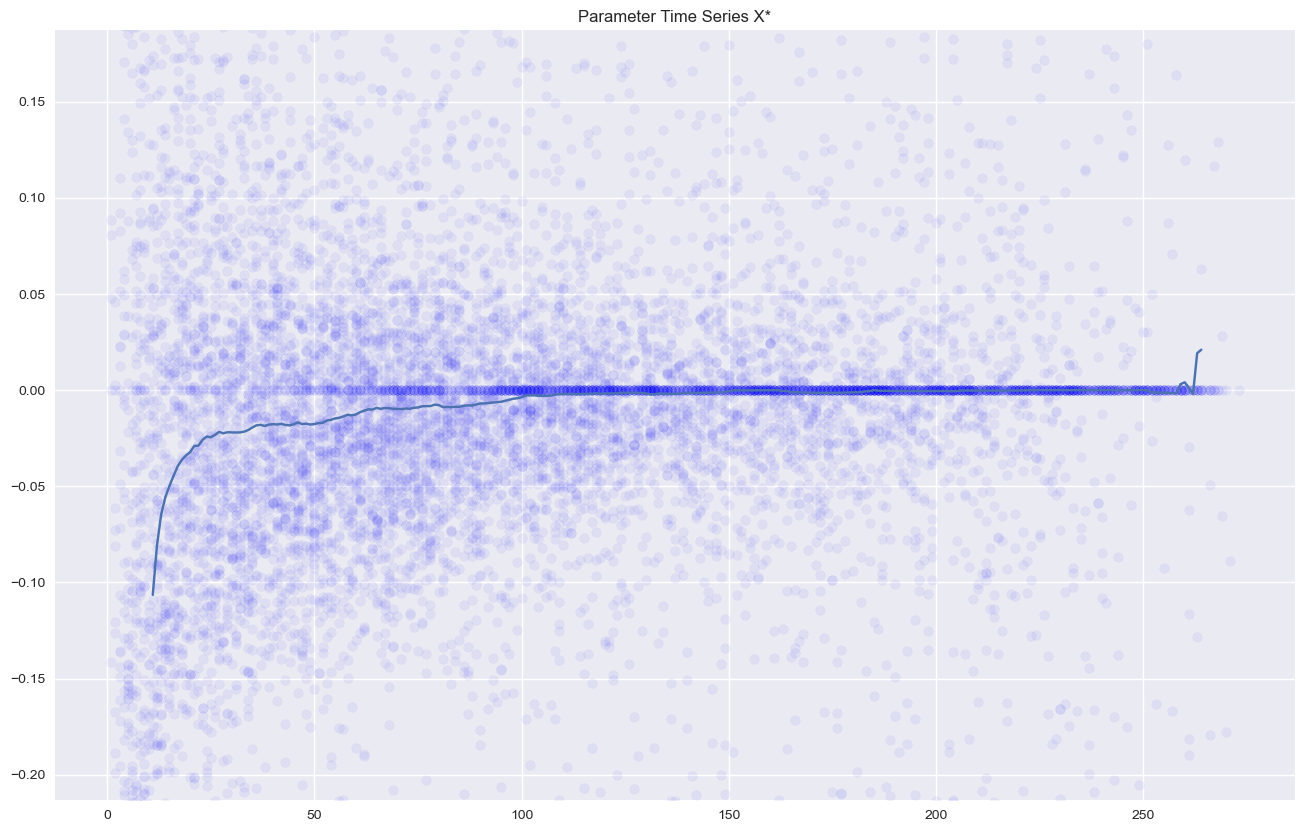

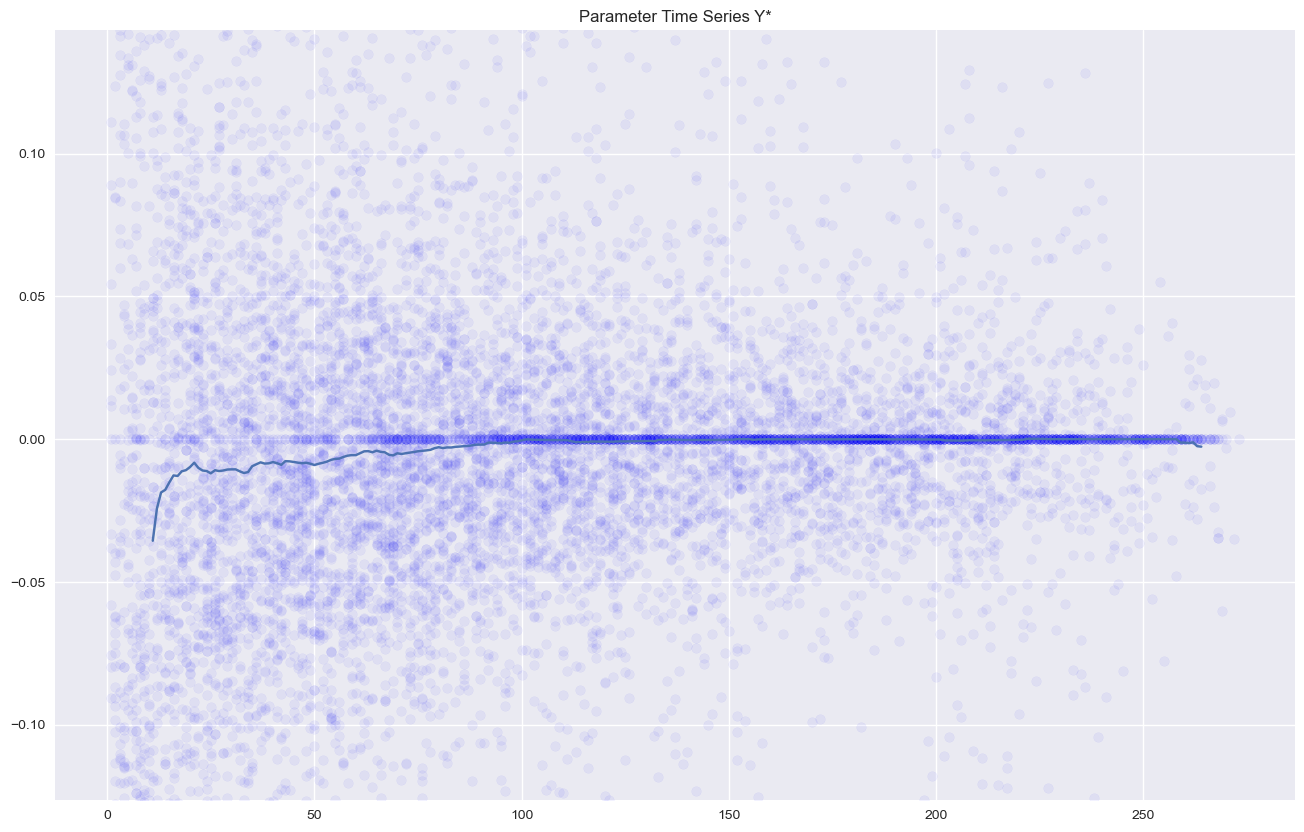

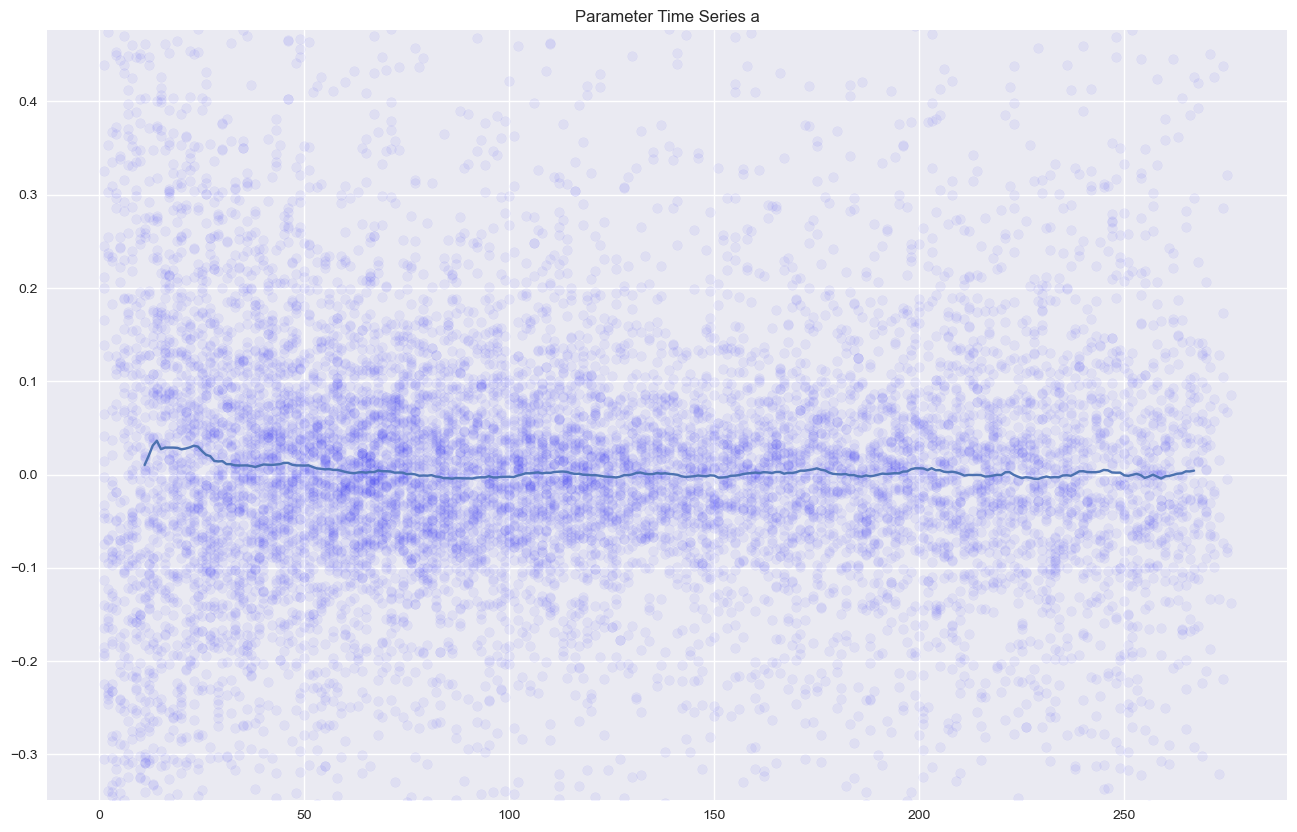

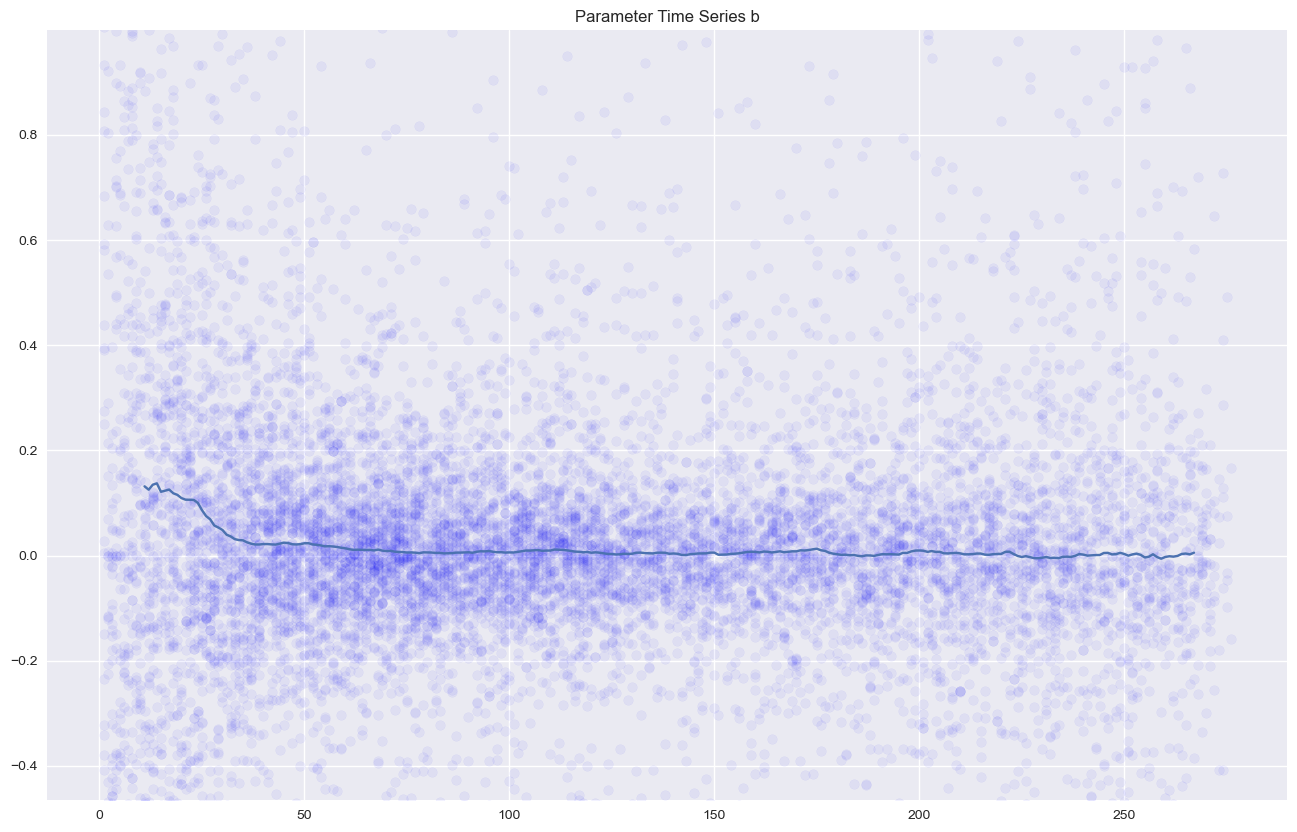

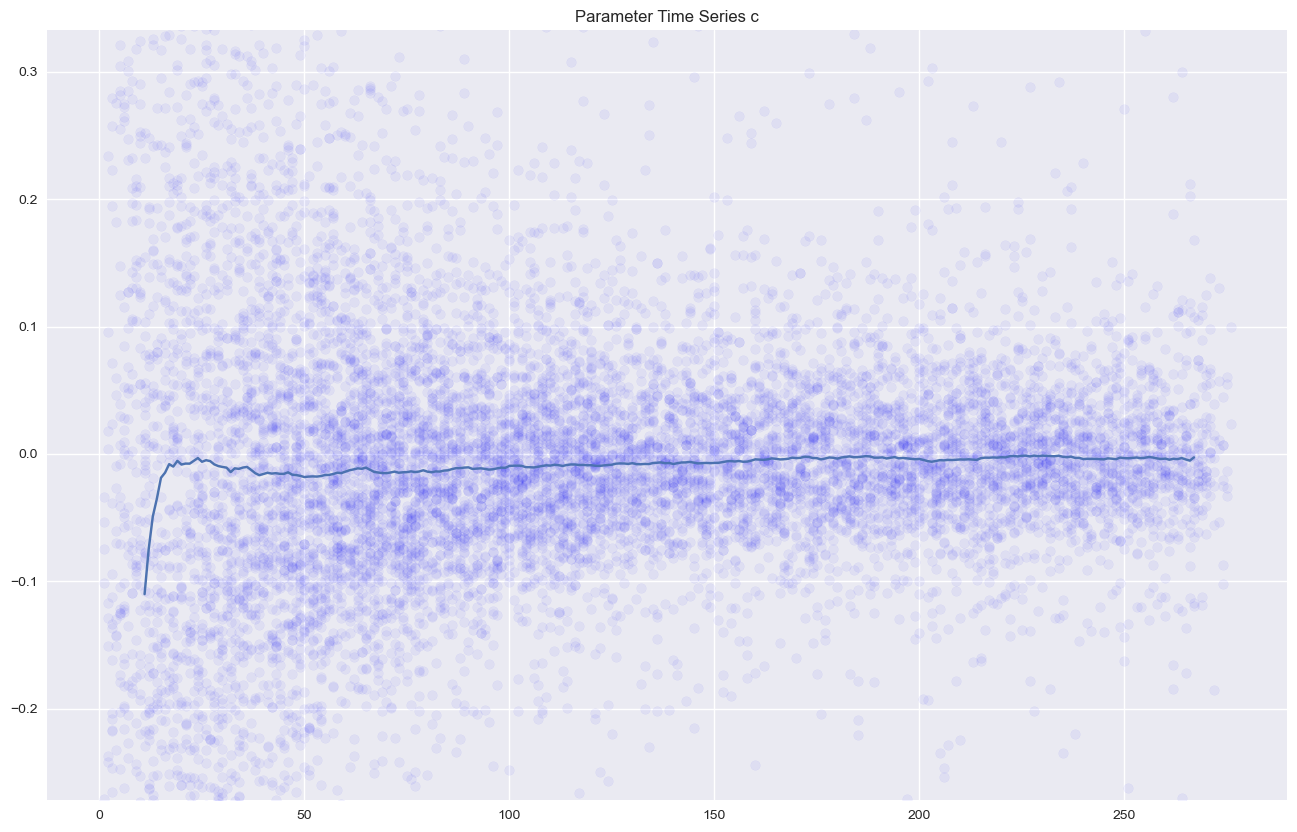

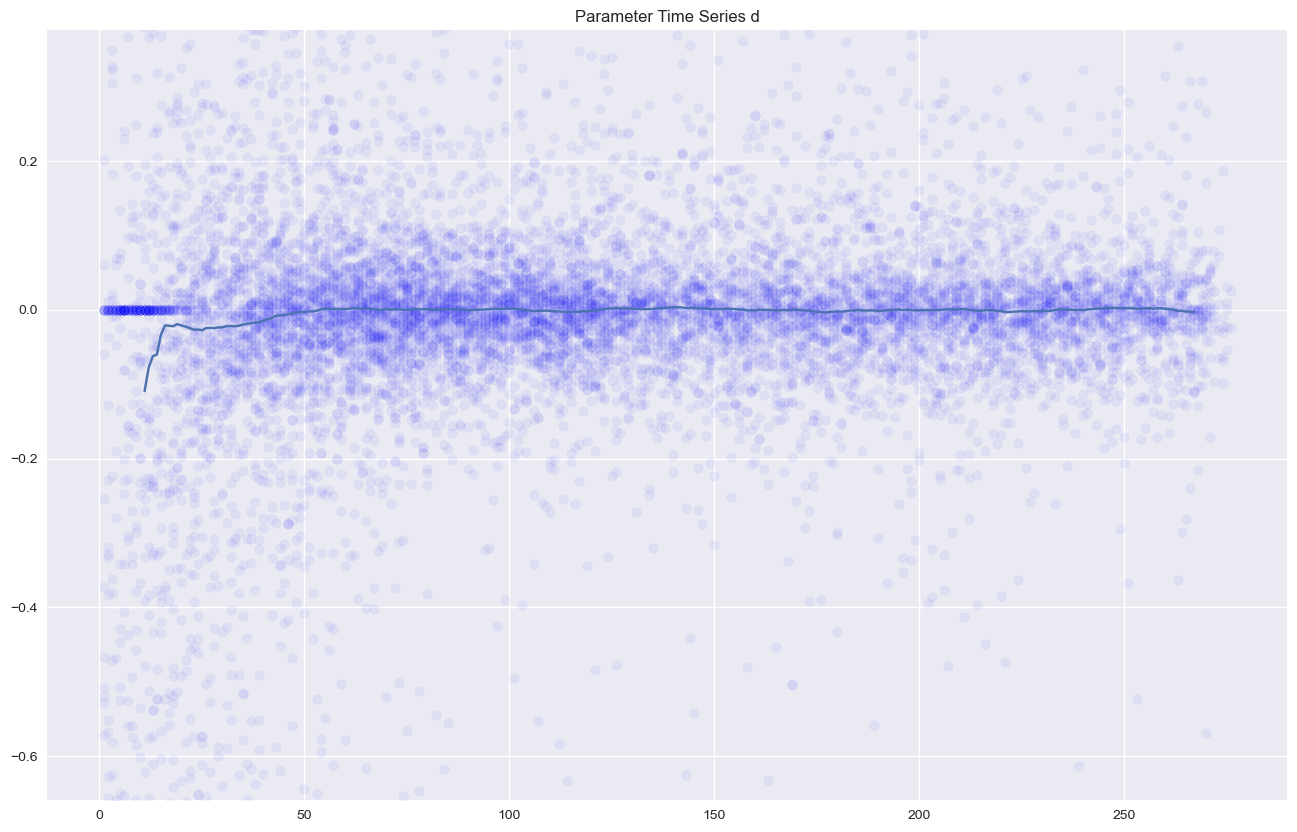

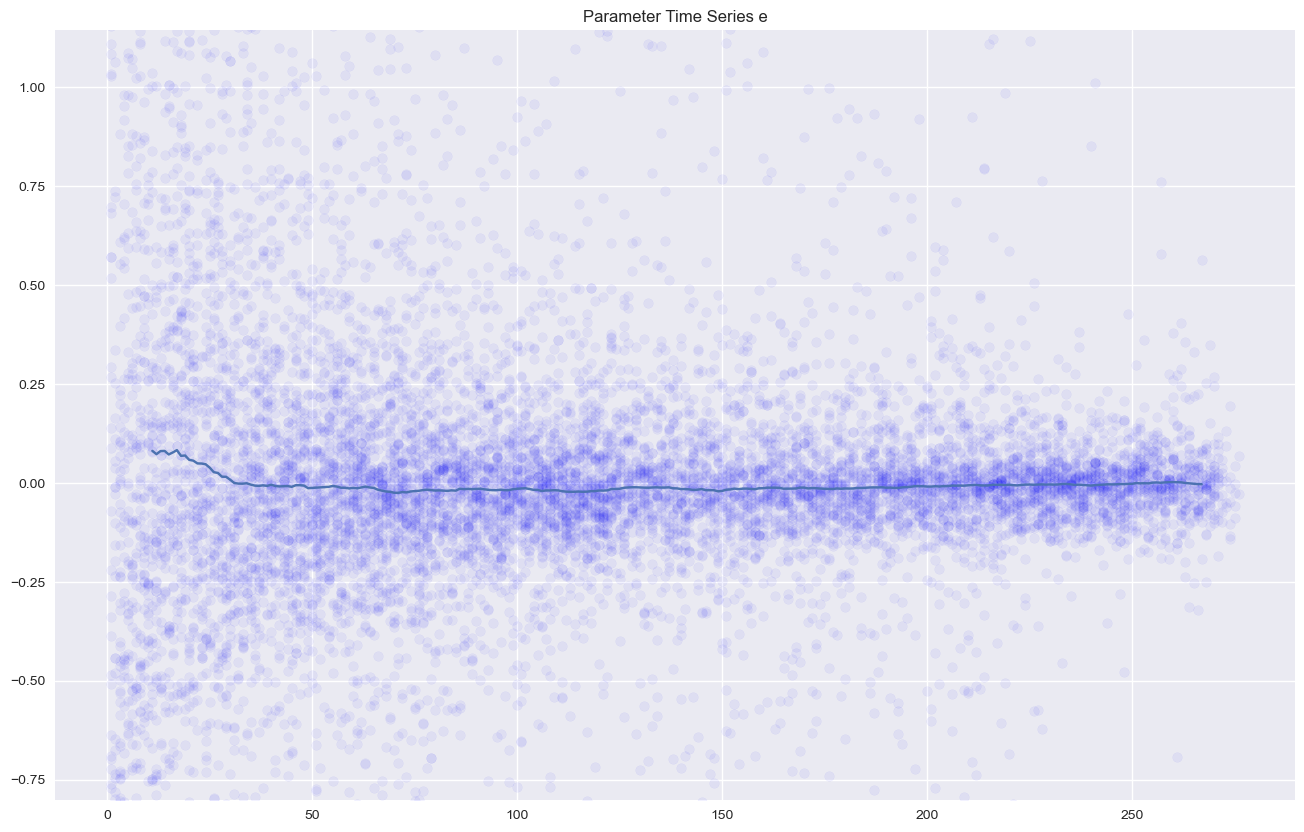

In [8]:
QT = 0.05
win = 20

def param_chg(df):
    df = df.copy()
    df[cols] = df[cols].pct_change()
    return df

param_chg = param_ts.groupby("EXP", group_keys=False).apply(param_chg)
param_med = param_chg.groupby("BUS_DAYS").median(numeric_only=True).reset_index()

param_med[cols] = param_med[cols].rolling(win, 
    win_type="gaussian", center=True).mean(std=win/2)

for c in ["ASYM", "X*", "Y*"] + param_cols:
    for exp in framework.expu:
        if True: #pd.to_datetime(exp).month%3==0:
            plt.scatter(param_chg.loc[param_chg["EXP"]==exp, "BUS_DAYS"], 
                     param_chg.loc[param_chg["EXP"]==exp, c], color='b', 
                     alpha=0.05, label=exp)
    
    plt.plot(param_med["BUS_DAYS"], param_med[c])
    
    # plt.legend()
    plt.title(f"Parameter Time Series {c}")
    plt.ylim([min(param_chg[c].quantile(QT), 0), 
              param_chg[c].quantile(1-QT)])
    plt.show()

In [21]:
param_med = param_med.shift(-1).fillna(0)
param_med['a'] = np.maximum(param_med['a'], 0)
param_med['b'] = np.maximum(param_med['b'], 0)

param_med[[chr(i) for i in range(97,102)]].to_pickle("hyperbola_med_chg.pkl")

In [9]:
param_ts[(param_ts["BUS_DAYS"]<126) & ((param_ts["EXP"].dt.month % 3)==0)]

TS        EXP       a       b       c       d       e    ASYM  \
0   2017-07-03 2017-09-15  0.0762  0.0194  0.0495 -0.0083 -0.0140  0.2457   
1   2017-07-05 2017-09-15  0.0824  0.0215  0.0461 -0.0130 -0.0164  0.2479   
2   2017-07-06 2017-09-15  0.0829  0.0233  0.0553 -0.0046 -0.0178  0.2770   
3   2017-07-07 2017-09-15  0.0931  0.0279  0.0545  0.0062 -0.0227  0.3056   
4   2017-07-10 2017-09-15  0.0959  0.0295  0.0542  0.0115 -0.0245  0.3195   
..         ...        ...     ...     ...     ...     ...     ...     ...   
151 2022-03-25 2022-09-16  0.0421  0.0054  0.0895 -0.1147  0.0169  0.0132   
152 2022-03-28 2022-09-16  0.0466  0.0062  0.0847 -0.1134  0.0154  0.0199   
153 2022-03-29 2022-09-16  0.0504  0.0069  0.0797 -0.1086  0.0143  0.0278   
154 2022-03-30 2022-09-16  0.0437  0.0057  0.0820 -0.1141  0.0159  0.0169   
155 2022-03-31 2022-09-16  0.0376  0.0047  0.0856 -0.1243  0.0183  0.0006   

         X*      Y*  BUS_DAYS  
0    0.0520  0.0054        52  
1    0.0502  0.0050        51  
2    0.0566  0.0056        50  
3    0.0526  0.0051        49  
4    0.0506  0.0050        48  
..      ...     ...       ...  
151  0.1747  0.0193       120  
152  0.1600  0.0187       119  
153  0.1460  0.0184       118  
154  0.1594  0.0187       117  
155  0.4549  0.0188       116  

[2371 rows x 11 columns]

In [10]:
framework.ivts

TS        EXP  STRIKE TYPE  BID_CLOSE  MID_CLOSE  ASK_CLOSE  \
0       2017-07-03 2017-07-21    2430    C       16.4      17.05       17.7   
1       2017-07-03 2017-07-21    2425    P       18.0      18.50       19.0   
2       2017-07-03 2017-07-21    2435    C       13.7      14.35       15.0   
3       2017-07-03 2017-07-21    2420    P       16.2      16.70       17.2   
4       2017-07-03 2017-07-21    2440    C       11.2      11.80       12.4   
...            ...        ...     ...  ...        ...        ...        ...   
1156195 2022-03-31 2023-03-17    5300    C       50.1      64.60       79.1   
1156196 2022-03-31 2023-03-17    5325    C       44.8      54.80       64.8   
1156197 2022-03-31 2023-03-17    5350    C       40.5      50.35       60.2   
1156198 2022-03-31 2023-03-17    5375    C       37.2      46.75       56.3   
1156199 2022-03-31 2023-03-17    5400    C       36.8      46.80       56.8   

         VOLUME  OPEN_INT  UNDERLYING_PRICE    DIFF  RANK  BUS_DAYS  CAL_DAYS  \
0           374      6981           2429.01    0.99     0        13        18   
1           373     38136           2429.01    4.01     1        13        18   
2          1402      3803           2429.01    5.99     2        13        18   
3           115      7518           2429.01    9.01     3        13        18   
4           634     14808           2429.01   10.99     4        13        18   
...         ...       ...               ...     ...   ...       ...       ...   
1156195       1      1183           4530.41  769.59    60       242       351   
1156196       0        97           4530.41  794.59    61       242       351   
1156197     140       666           4530.41  819.59    62       242       351   
1156198       0        43           4530.41  844.59    63       242       351   
1156199       0       779           4530.41  869.59    64       242       351   

         RATE_OLS  RATE_OPEN_INT  RATE_VOLUME  RATE_MONEYNESS    F_T_OLS  \
0          0.0211         0.0220       0.0138          0.0162  2426.4748   
1          0.0211         0.0220       0.0138          0.0162  2426.4748   
2          0.0211         0.0220       0.0138          0.0162  2426.4748   
3          0.0211         0.0220       0.0138          0.0162  2426.4748   
4          0.0211         0.0220       0.0138          0.0162  2426.4748   
...           ...            ...          ...             ...        ...   
1156195    0.0179         0.0183       0.0175          0.0185  4567.4657   
1156196    0.0179         0.0183       0.0175          0.0185  4567.4657   
1156197    0.0179         0.0183       0.0175          0.0185  4567.4657   
1156198    0.0179         0.0183       0.0175          0.0185  4567.4657   
1156199    0.0179         0.0183       0.0175          0.0185  4567.4657   

         F_T_OPEN_INT  F_T_VOLUME  F_T_MONEYNESS    RATE        F_T  IV_BID  \
0           2426.5318   2426.4955      2426.4824  0.0220  2426.5318  0.0823   
1           2426.5318   2426.4955      2426.4824  0.0220  2426.5318  0.0854   
2           2426.5318   2426.4955      2426.4824  0.0220  2426.5318  0.0800   
3           2426.5318   2426.4955      2426.4824  0.0220  2426.5318  0.0879   
4           2426.5318   2426.4955      2426.4824  0.0220  2426.5318  0.0776   
...               ...         ...            ...     ...        ...     ...   
1156195     4567.5692   4567.3136      4567.7985  0.0183  4567.5692  0.1430   
1156196     4567.5692   4567.3136      4567.7985  0.0183  4567.5692  0.1409   
1156197     4567.5692   4567.3136      4567.7985  0.0183  4567.5692  0.1394   
1156198     4567.5692   4567.3136      4567.7985  0.0183  4567.5692  0.1386   
1156199     4567.5692   4567.3136      4567.7985  0.0183  4567.5692  0.1409   

         IV_MID  IV_ASK  LOG_MONEYNESS_F  IVAR_MID  
0        0.0852  0.0882           0.0014    0.0073  
1        0.0877  0.0900          -0.0006    0.0077  
2        0.0830  0.0860           0.0035    0.0069  
3        0.0902  0.0

In [11]:
cl = [chr(i) for i in range(97,107)]
il = [i for i in range(10)]

zl = list(zip(cl, il))
zl

[('a', 0),
 ('b', 1),
 ('c', 2),
 ('d', 3),
 ('e', 4),
 ('f', 5),
 ('g', 6),
 ('h', 7),
 ('i', 8),
 ('j', 9)]